Algorithm comparison

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [2]:
%run ../../../utils/Python/setup_environment.ipy
%run ../../../utils/Python/selene_job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

# Get the data

In [3]:
data = Impact_Wrapper('../../../data/impact_181105/annotated_final_IMPACT_mutations_181105.txt', 'is_artefact')
data.impact = data.impact.drop('variant_caller_cv', axis=1)

In [4]:
data.impact[data.impact['frequency_in_normals'].isna()].shape

(174, 64)

In [5]:
data.impact.loc[data.impact['frequency_in_normals'].isna(), 'frequency_in_normals'] = 0.0
data.impact[data.impact['frequency_in_normals'].isna()].shape

(0, 64)

In [6]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
            'gene_type']

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (225561, 45) | y: (225561,)


,count_,freq_
False,218425,96.84%
True,7136,3.16%


In [7]:
X.head()

,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,sample_coverage,frequency_in_normals,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_total_AF_AFR,VEP_gnomAD_total_AF_AMR,VEP_gnomAD_total_AF_ASJ,VEP_gnomAD_total_AF_EAS,VEP_gnomAD_total_AF_FIN,VEP_gnomAD_total_AF_NFE,VEP_gnomAD_total_AF_OTH,VEP_gnomAD_total_AF_max,VEP_gnomAD_total_AF,VEP_Consequence_frameshift_variant,VEP_Consequence_inframe_deletion,VEP_Consequence_inframe_insertion,VEP_Consequence_missense_variant,VEP_Consequence_splice_acceptor_variant,VEP_Consequence_splice_donor_variant,VEP_Consequence_start_lost,VEP_Consequence_stop_gained,VEP_Consequence_stop_lost,VEP_VARIANT_CLASS_SNV,VEP_VARIANT_CLASS_deletion,VEP_VARIANT_CLASS_indel,VEP_VARIANT_CLASS_insertion,VEP_VARIANT_CLASS_sequence_alteration,VEP_VARIANT_CLASS_substitution,VEP_IMPACT_HIGH,VEP_IMPACT_MODERATE,VEP_CLIN_SIG_benign,VEP_CLIN_SIG_pathogenic,VEP_CLIN_SIG_unknown,VEP_in_dbSNP_False,VEP_in_dbSNP_True,gene_type_oncogene,gene_type_oncogene_and_tsg,gene_type_tsg,gene_type_unknown
132429,969.0,0.32817,318.0,918.0,0.00218,2.0,827.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
198630,292.0,0.06507,19.0,325.0,0.00000,0.0,405.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
28359,823.0,0.13001,107.0,695.0,0.00144,1.0,628.0,0.000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
188831,879.0,0.10125,89.0,569.0,0.00000,0.0,836.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
187954,374.0,0.09358,35.0,297.0,0.00000,0.0,584.0,0.022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


# Set cross-validation strategies and load some modules

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [8]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

In [9]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

In [42]:
# create object to holds results
summary = Summary()

# Uniform

Generates predictions uniformly at random, expected accuracy: 0.5 | expected AUC: 0.5.

In [43]:
from sklearn.dummy import DummyClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      DummyClassifier(strategy='uniform', random_state=42))

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (6.25s)
▴ Mean average_precision: 0.032 ± 0.000
▴ Mean roc_auc          : 0.500 ± 0.000
▴ Mean precision        : 0.031 ± 0.001
▴ Mean recall           : 0.497 ± 0.009
▴ Mean f1               : 0.059 ± 0.001
▴ Mean accuracy         : 0.500 ± 0.001


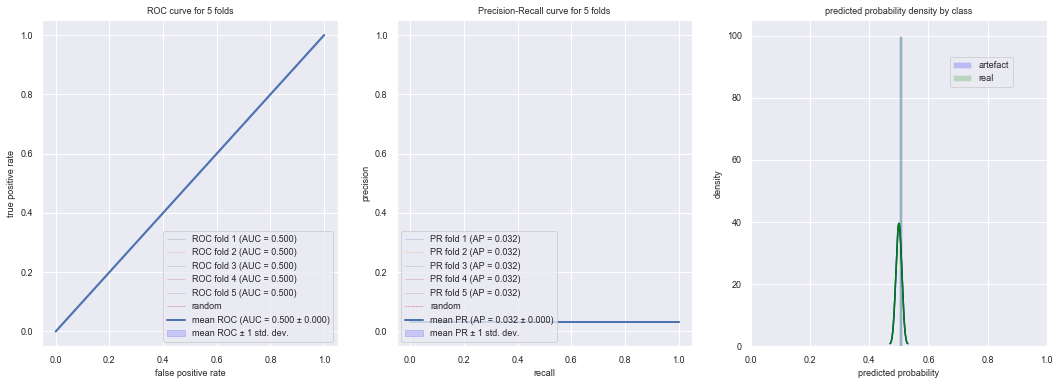

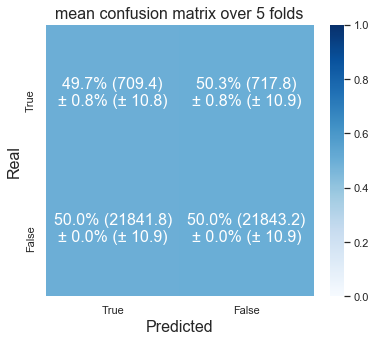

In [44]:
metrics.plot_threshold_decision_curves(figsize=(18, 6), plot_thresholds=False)
metrics.plot_mean_confusion_matrix()

In [45]:
#metrics.get_learning_curves_metrics()
#metrics.plot_learning_curves(figsize=(6, 6))

In [46]:
summary.add(metrics, 'Uniform', 'mediumseagreen')

# Most Frequent

Always predicts the most frequent label in the training set → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [47]:
model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      DummyClassifier(strategy='most_frequent', random_state=42))

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model...

/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site

 done! (5.50s)
▴ Mean average_precision: 0.032 ± 0.000
▴ Mean roc_auc          : 0.500 ± 0.000
▴ Mean precision        : 0.000 ± 0.000
▴ Mean recall           : 0.000 ± 0.000
▴ Mean f1               : 0.000 ± 0.000
▴ Mean accuracy         : 0.968 ± 0.000


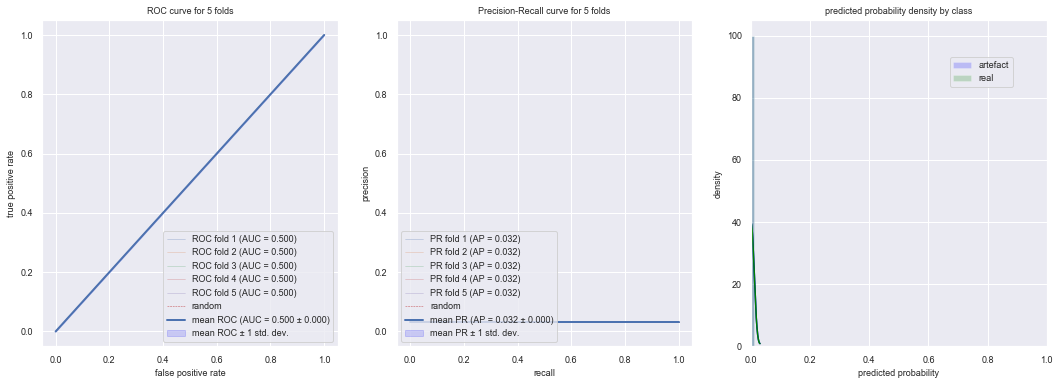

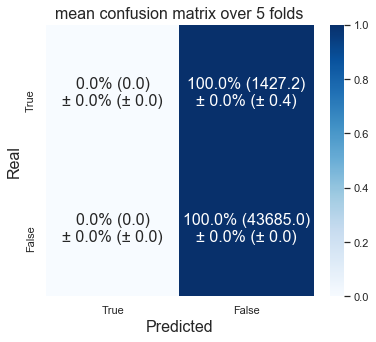

In [48]:
metrics.plot_threshold_decision_curves(figsize=(18, 6), plot_thresholds=False)
metrics.plot_mean_confusion_matrix()

In [49]:
summary.add(metrics, 'MostFrequent', 'seagreen')

# Gaussian Naive Bayes

In [50]:
from sklearn.naive_bayes import GaussianNB

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      GaussianNB())

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (18.15s)
▴ Mean average_precision: 0.245 ± 0.026
▴ Mean roc_auc          : 0.819 ± 0.012
▴ Mean precision        : 0.331 ± 0.061
▴ Mean recall           : 0.409 ± 0.022
▴ Mean f1               : 0.362 ± 0.031
▴ Mean accuracy         : 0.954 ± 0.007


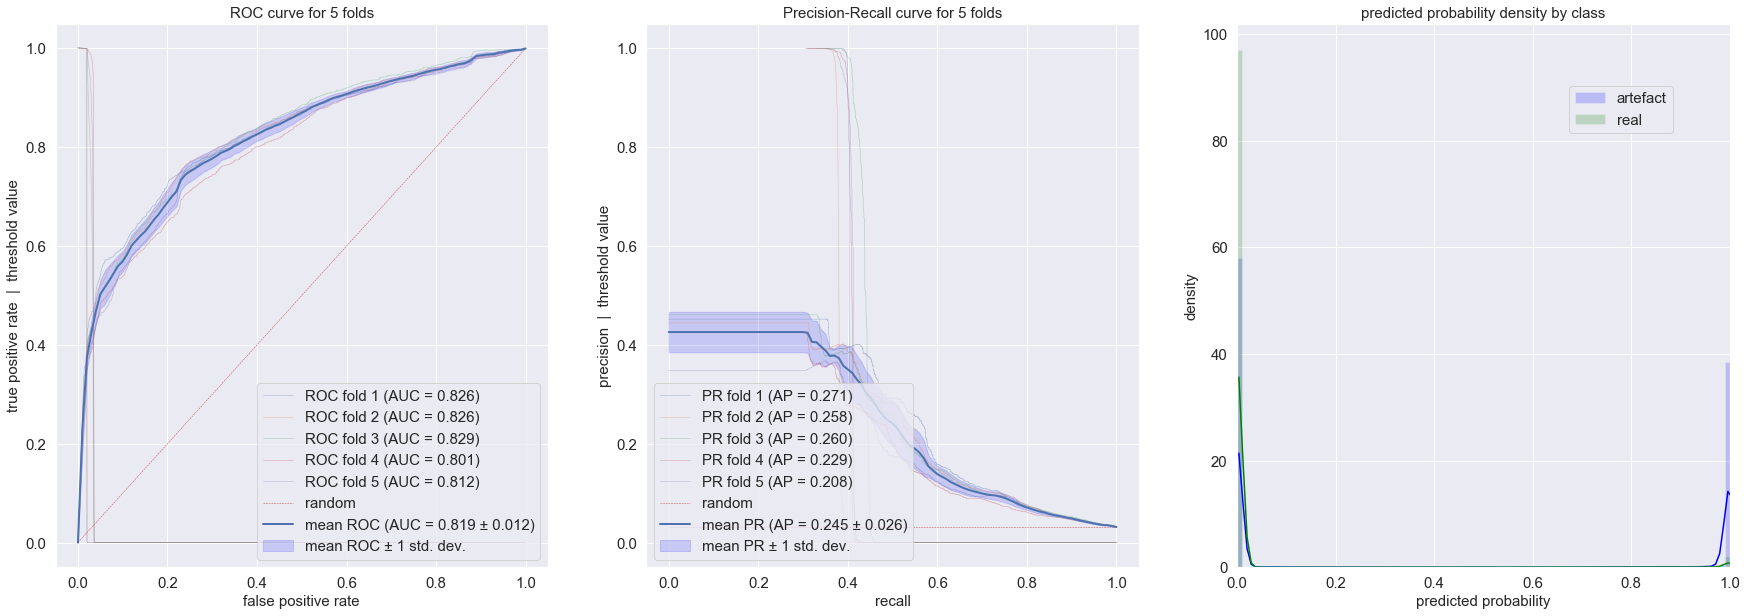

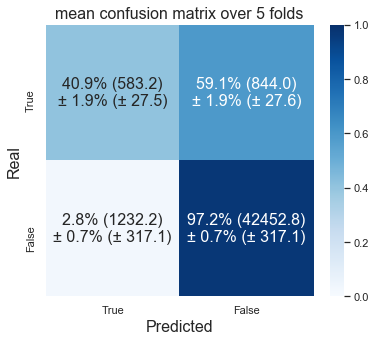

In [51]:
metrics.plot_threshold_decision_curves()
metrics.plot_mean_confusion_matrix()

In [52]:
summary.add(metrics, 'GausssianNaiveBayes', 'darkgoldenrod')

# Ridge regression (L2 regularization)

This model performs an automatic grid search over its parameters.

In [53]:
from sklearn.linear_model import LogisticRegressionCV

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42, max_iter=1000))

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (26.23s)
▴ Mean average_precision: 0.396 ± 0.015
▴ Mean roc_auc          : 0.841 ± 0.008
▴ Mean precision        : 0.175 ± 0.009
▴ Mean recall           : 0.636 ± 0.016
▴ Mean f1               : 0.274 ± 0.012
▴ Mean accuracy         : 0.893 ± 0.005


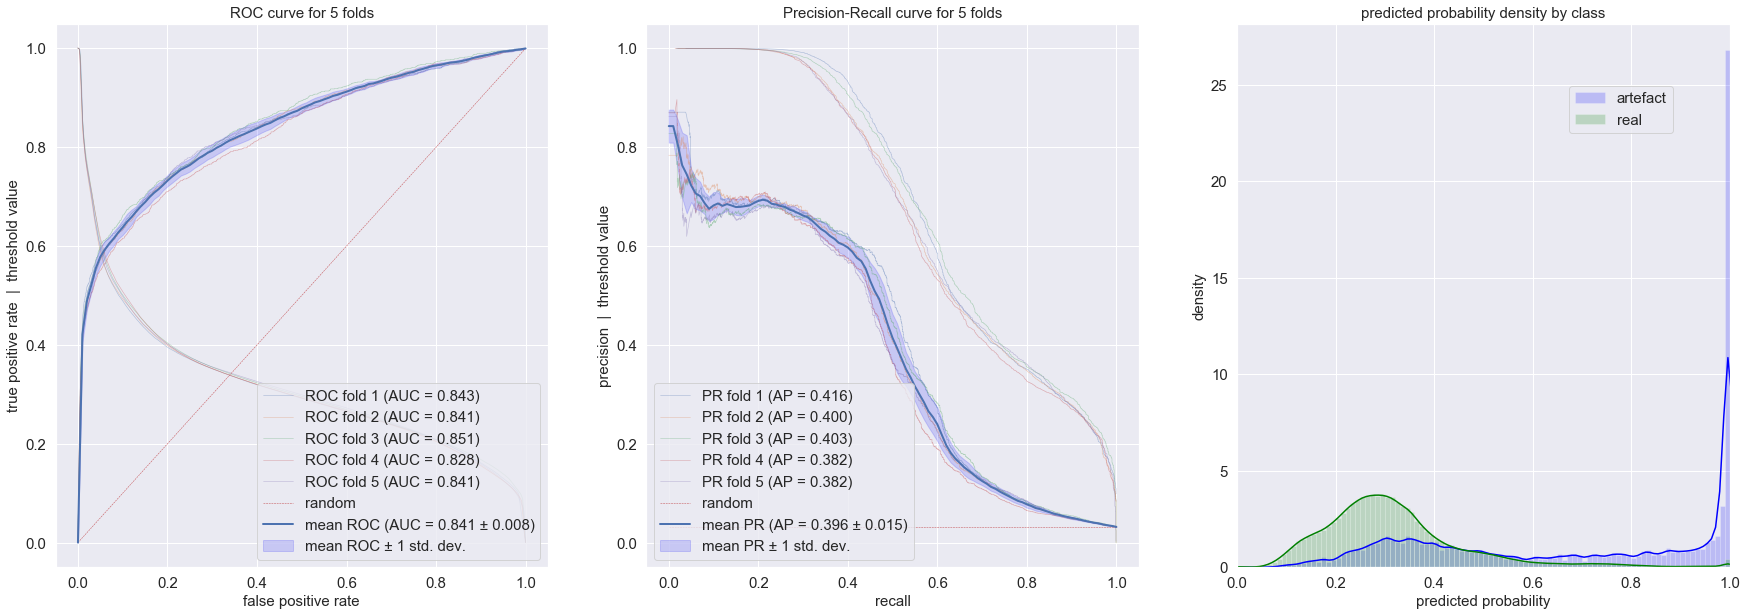

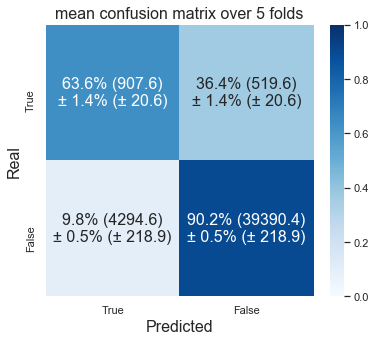

In [54]:
metrics.plot_threshold_decision_curves()
metrics.plot_mean_confusion_matrix()

In [55]:
summary.add(metrics, 'RidgeRegression', 'salmon')

"If your variables are positively correlated, then the coefficients will be negatively correlated, which can lead to a wrong sign on one of the coefficients.", see https://stats.stackexchange.com/questions/1580/regression-coefficients-that-flip-sign-after-including-other-predictors.

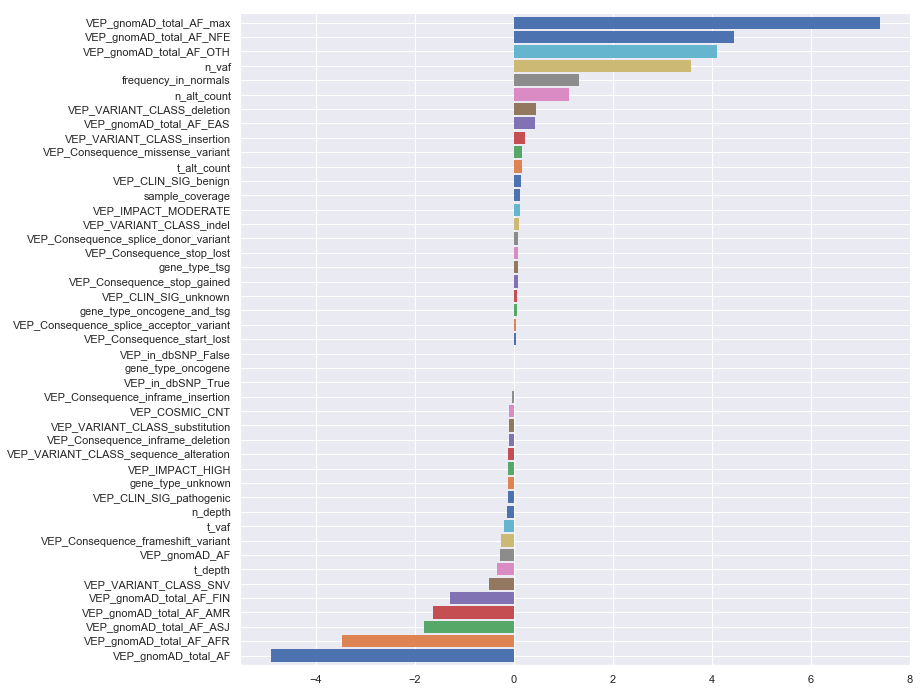

In [56]:
model.fit(X, y)

feature_coefficient = pd.DataFrame({'coeff': model.named_steps['logisticregressioncv'].coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 12))
feature_coefficient.coeff.plot.barh(width=0.85, linewidth=0);

# Lasso regression (L1 regularization)

In [37]:
from sklearn.linear_model import LogisticRegressionCV

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', random_state=42, max_iter=1000))

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (145.50s)
▴ Mean average_precision: 0.496 ± 0.013
▴ Mean roc_auc          : 0.845 ± 0.007
▴ Mean precision        : 0.198 ± 0.013
▴ Mean recall           : 0.665 ± 0.006
▴ Mean f1               : 0.305 ± 0.015
▴ Mean accuracy         : 0.888 ± 0.007


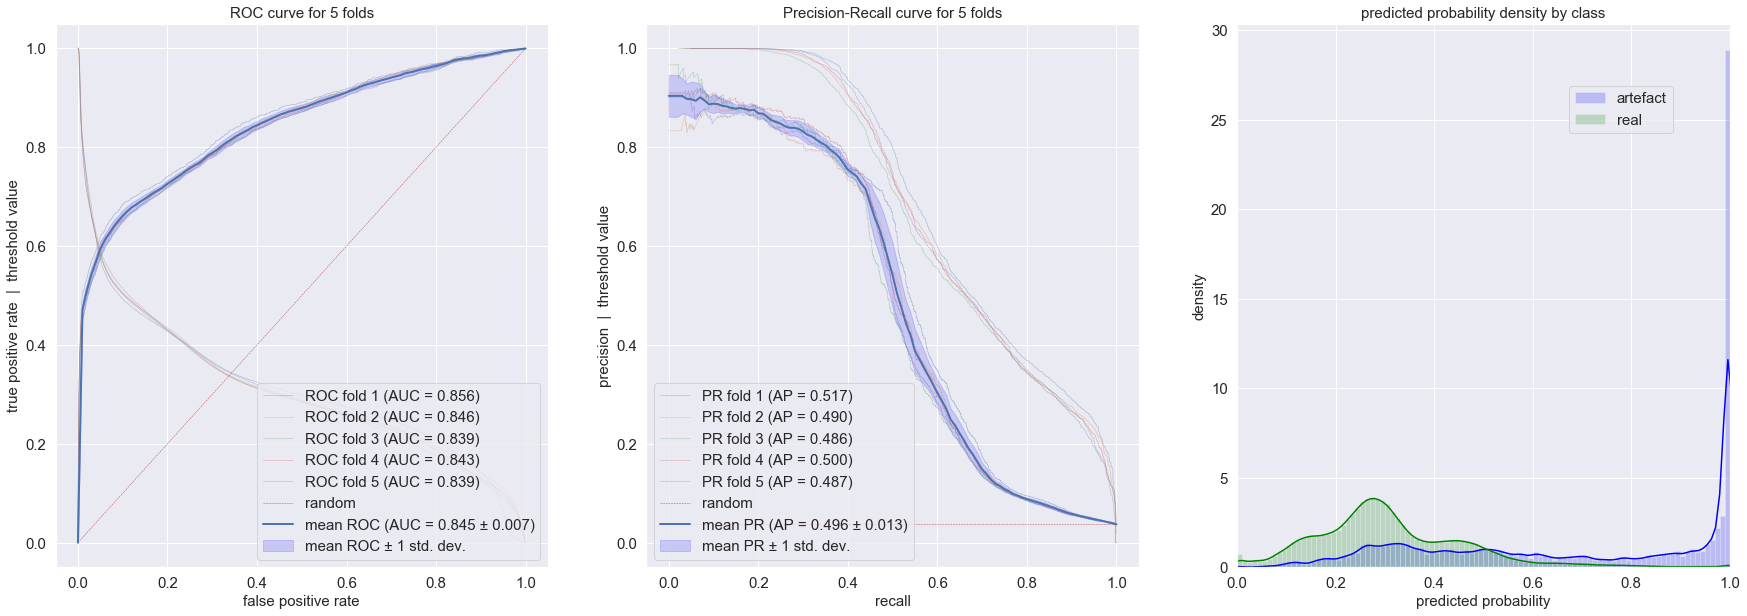

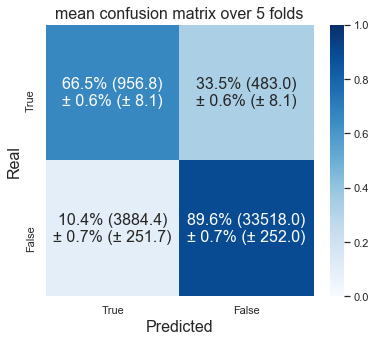

In [38]:
metrics.plot_threshold_decision_curves()
metrics.plot_mean_confusion_matrix()

In [39]:
summary.add(metrics, 'LassoRegression', 'crimson')

We change the regularization to make it stronger (otherwise we get the same result as for the ridge regression previously):

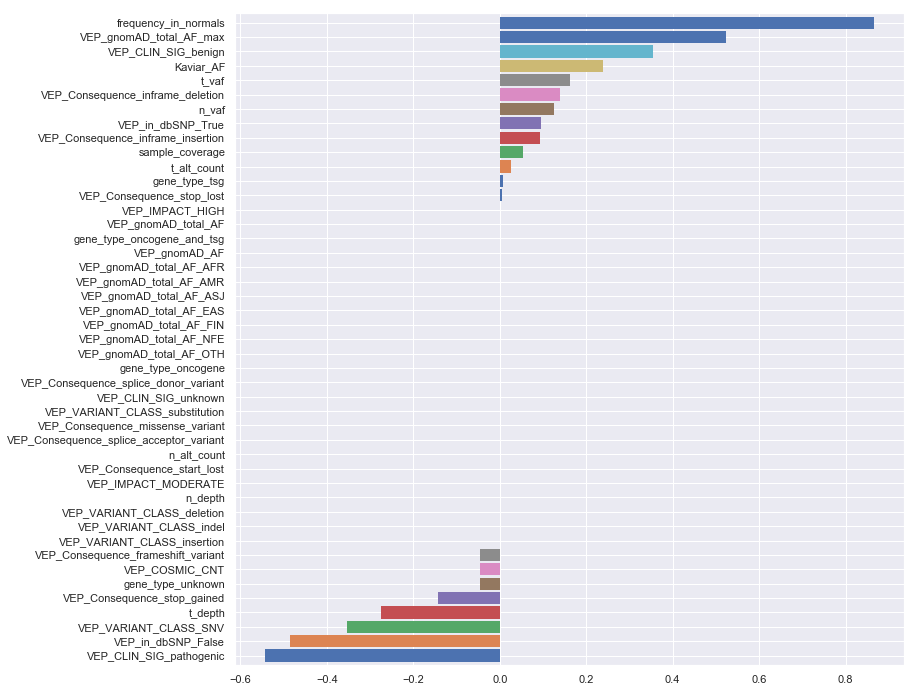

In [40]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=0.01))
model.fit(X, y)

feature_coefficient = pd.DataFrame({'coeff': model.named_steps['logisticregression'].coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 12))
feature_coefficient.coeff.plot.barh(width=0.85, linewidth=0);

# K Nearest Neighbors

In [44]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')

<span style="color:red">Job < kNN >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

In [41]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < kNN >: </span>✅ job found and reloaded

In [46]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_kNN


<span style="color:green">Job < kNN >: </span>✅ data loaded

In [88]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/Python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# choose a model and run it
from sklearn.neighbors import KNeighborsClassifier
parameters_grid = [
                    {'kneighborsclassifier__n_neighbors': [10, 15, 20, 25, 30, 40, 50, 60, 100],
                     'kneighborsclassifier__weights': ['uniform', 'distance']}
                  ]
pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     StandardScaler(),
                     KNeighborsClassifier())

model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_kNN/script.ipy


In [89]:
job.run(n_jobs=5, short_job=False)

➞ scp ssh_remote_jobs/job_kNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs
job_output.txt                                100% 1494    72.5KB/s   00:00    
metrics.pkl                                   100% 6502KB  13.7MB/s   00:00    
script.ipy                                    100% 1279    36.7KB/s   00:00    
X.pkl                                         100%   44MB  11.1MB/s   00:04    
y.pkl                                         100% 3225KB   9.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_kNN
Job <30234963> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J kNN -n 5 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < kNN >: </span>✅ submitted<br>

In [42]:
job.get_results()

<span style="color:green">Job < kNN >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_kNN to ssh_remote_jobs/job_kNN
metrics.pkl                                   100% 6502KB   5.2MB/s   00:01    
job_output.txt                                100% 1497   313.8KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.475 ± 0.016
▴ Mean roc_auc          : 0.860 ± 0.007
▴ Mean precision        : 0.185 ± 0.007
▴ Mean recall           : 0.692 ± 0.014
▴ Mean f1               : 0.292 ± 0.009
▴ Mean accuracy         : 0.876 ± 0.005


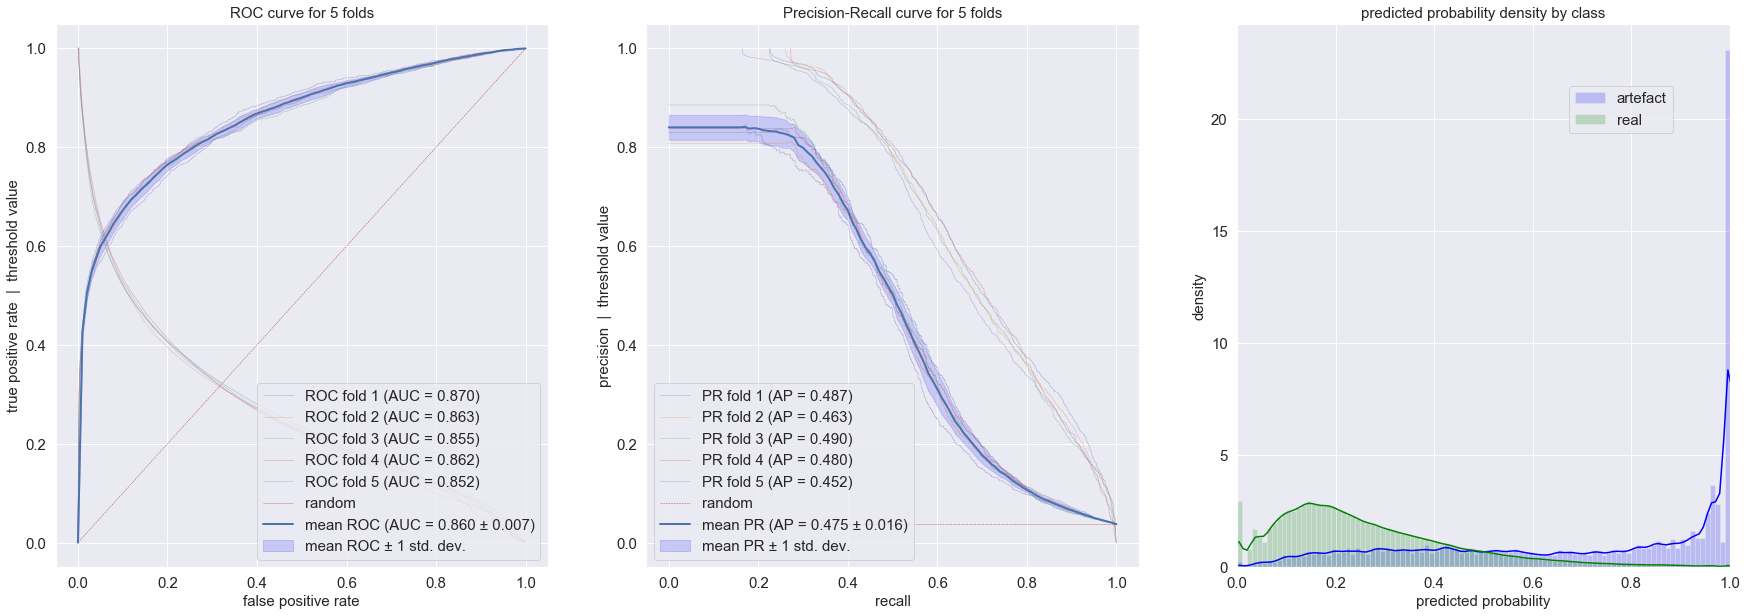

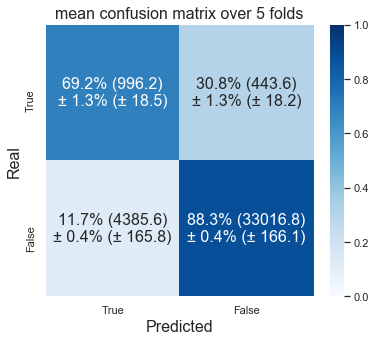

In [4]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → kneighborsclassifier__n_neighbors: [10 15 20 25 30 40 50 60 100]
  → kneighborsclassifier__weights    : ['distance' 'uniform']
Best hyperparameters for each fold:
fold 0: {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'distance'}
fold 1: {'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__weights': 'distance'}
fold 2: {'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__weights': 'distance'}
fold 3: {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance'}
fold 4: {'kneighborsclassifier__n_neighbors': 40, 'kneighborsclassifier__weights': 'distance'}


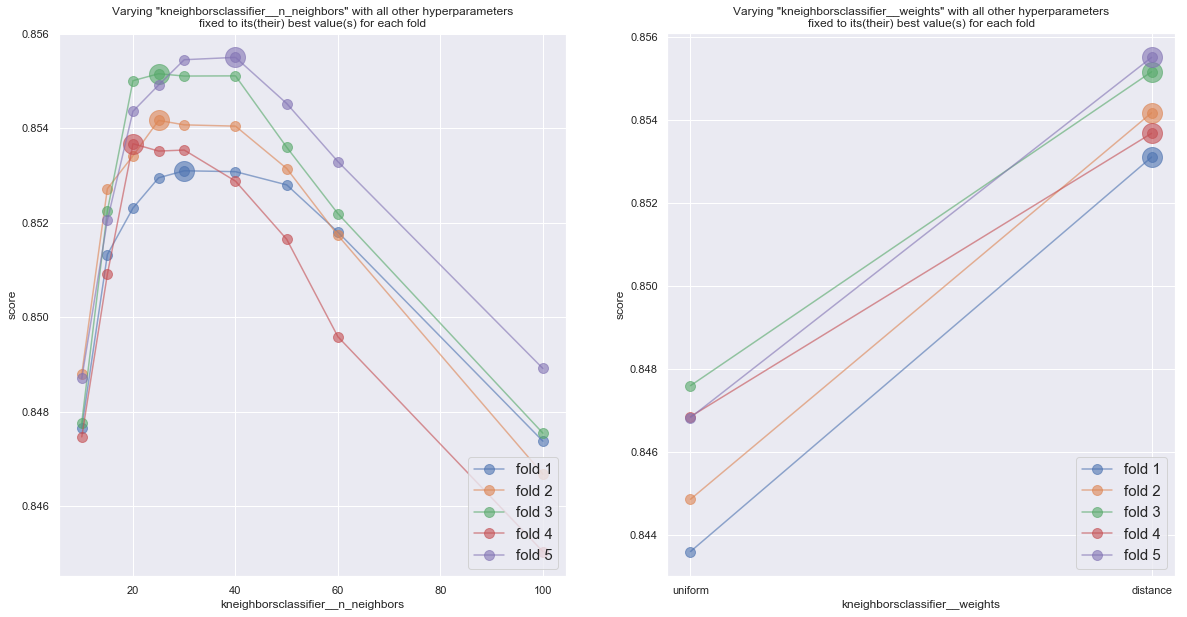

In [5]:
job.metrics.plot_grid_search_results(plot_error_bar = False)

In [43]:
summary.add(job.metrics, 'kNN', 'maroon')

# Support Vector Machine

In [59]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')

➞ mkdir on local computer ssh_remote_jobs/job_SVM


<span style="color:green">Job < SVM >: </span>✅ created

In [2]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < SVM >: </span>✅ job found and reloaded

In [58]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_SVM


<span style="color:green">Job < SVM >: </span>✅ data loaded

In [59]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/Python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# choose a model and run it
from sklearn.svm import SVC
parameters_grid = [
                    {'svc__C': [1, 5, 20, 30, 35, 40],
                     'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
                  ]
pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     StandardScaler(),
                     SVC(probability=True, cache_size=1000, gamma='scale'))
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_SVM/script.ipy


In [71]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ssh_remote_jobs/job_SVM to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_SVM
job_output.txt                                100% 1498   164.3KB/s   00:00    
metrics.pkl                                   100% 6596KB  14.8MB/s   00:00    
script.ipy                                    100% 1239    48.8KB/s   00:00    
X.pkl                                         100%   44MB   8.9MB/s   00:05    
y.pkl                                         100% 3225KB   8.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_SVM
Job <30363784> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J SVM -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < SVM >: </span>✅ submitted<br>

In [3]:
job.get_results()

<span style="color:green">Job < SVM >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_SVM to ssh_remote_jobs/job_SVM
metrics.pkl                                   100% 6572KB   9.4MB/s   00:00    
job_output.txt                                100% 1498    29.1KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.445 ± 0.008
▴ Mean roc_auc          : 0.857 ± 0.008
▴ Mean precision        : 0.228 ± 0.008
▴ Mean recall           : 0.675 ± 0.014
▴ Mean f1               : 0.341 ± 0.008
▴ Mean accuracy         : 0.903 ± 0.004


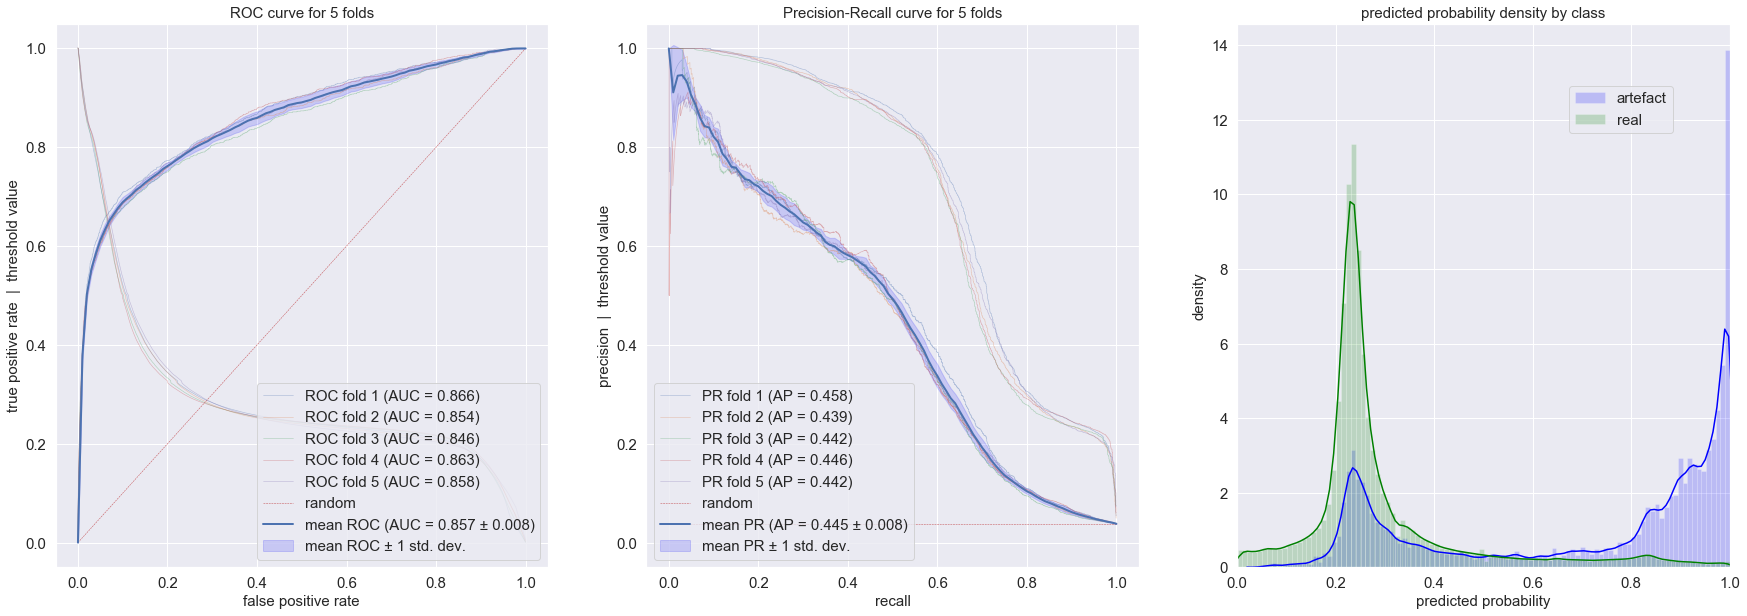

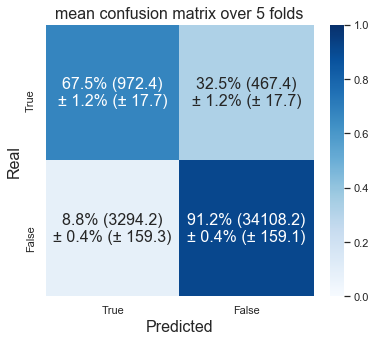

In [4]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → svc__C     : [1 5 20 30 35 40]
  → svc__kernel: ['linear' 'poly' 'rbf' 'sigmoid']
Best hyperparameters for each fold:
fold 0: {'svc__C': 30, 'svc__kernel': 'rbf'}
fold 1: {'svc__C': 40, 'svc__kernel': 'rbf'}
fold 2: {'svc__C': 35, 'svc__kernel': 'rbf'}
fold 3: {'svc__C': 30, 'svc__kernel': 'rbf'}
fold 4: {'svc__C': 30, 'svc__kernel': 'rbf'}


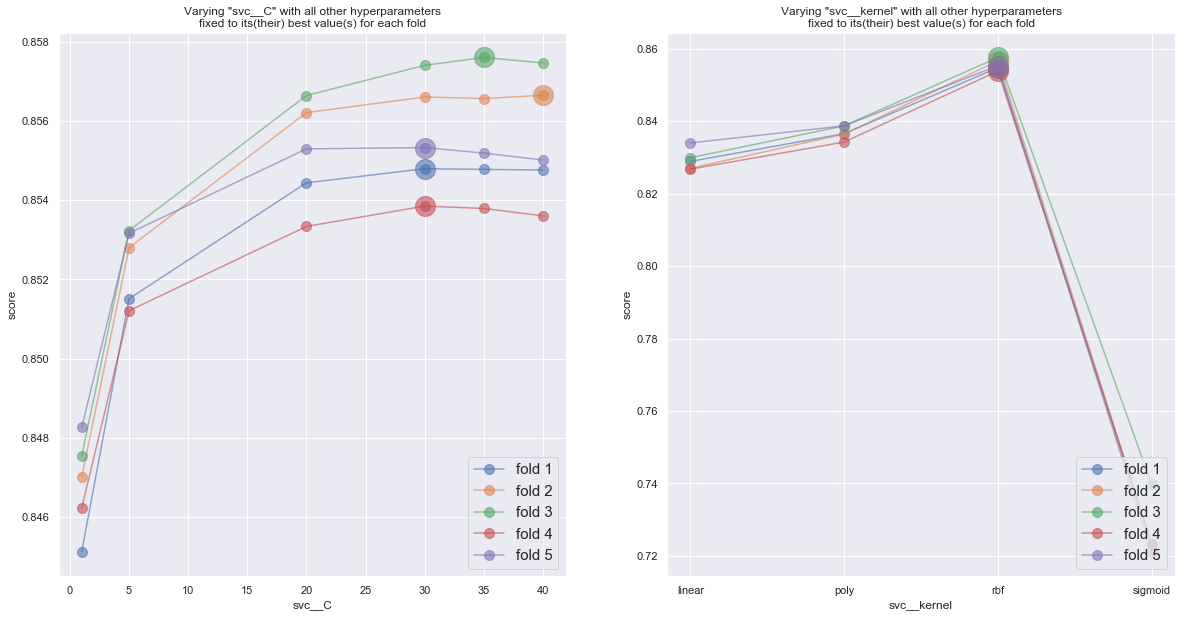

In [5]:
job.metrics.plot_grid_search_results(plot_error_bar = False)

In [46]:
summary.add(job.metrics, 'SVM', 'grey')

# Random Forest

In [10]:
job = Selene_Job('RandomForest_181105', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')

➞ mkdir on local computer ssh_remote_jobs/job_RandomForest_181105


<span style="color:green">Job < RandomForest_181105 >: </span>✅ created

In [11]:
job = Selene_Job('RandomForest_181105', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < RandomForest_181105 >: </span>✅ job found and reloaded

In [12]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_RandomForest_181105


<span style="color:green">Job < RandomForest_181105 >: </span>✅ data loaded

In [13]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/Python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
parameters_grid = [
                    {'randomforestclassifier__n_estimators': [100, 500, 1000, 1500],
                     'randomforestclassifier__criterion': ['gini', 'entropy'],
                     'randomforestclassifier__max_depth': [15, 18, 20, 22, 25, 30, 40, 50]}
                  ]

pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     RandomForestClassifier(random_state=42))
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_RandomForest_181105/script.ipy


In [14]:
job.run(n_jobs=20, short_job=False, memory=32)

➞ scp ssh_remote_jobs/job_RandomForest_181105 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_RandomForest_181105
script.ipy                                    100% 1338    74.3KB/s   00:00    
X.pkl                                         100%   50MB  12.9MB/s   00:03    
y.pkl                                         100% 3745KB  11.9MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_RandomForest_181105
Job <30397985> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_181105 -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_181105 >: </span>✅ submitted<br>

In [15]:
job.get_results()

<span style="color:red">Job < RandomForest_181105 >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.588 ± 0.014
▴ Mean roc_auc          : 0.894 ± 0.004
▴ Mean precision        : 0.224 ± 0.009
▴ Mean recall           : 0.739 ± 0.012
▴ Mean f1               : 0.343 ± 0.011
▴ Mean accuracy         : 0.895 ± 0.005


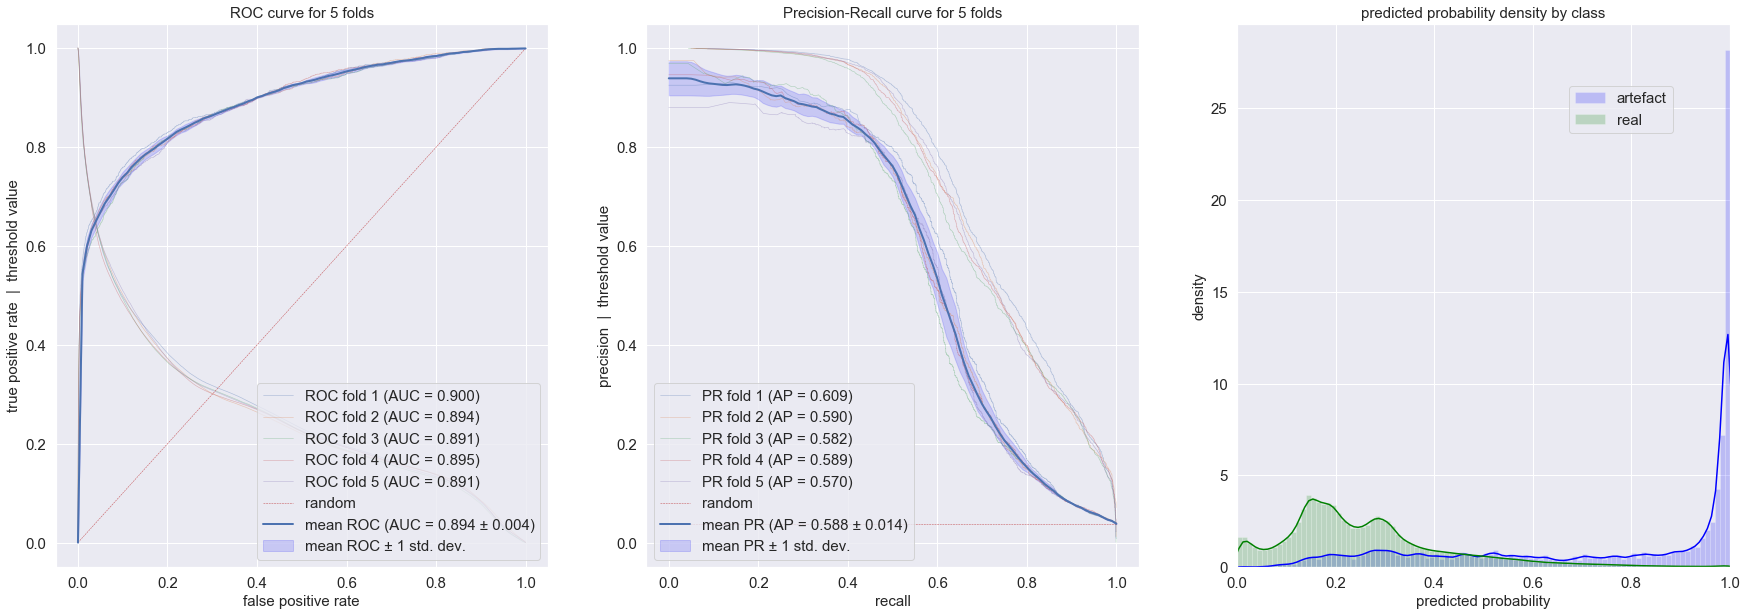

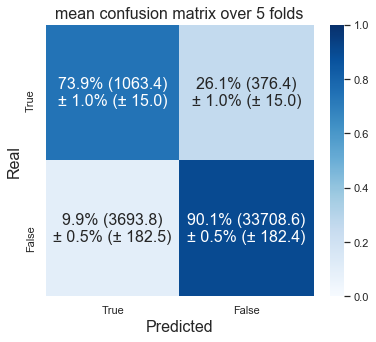

In [12]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → randomforestclassifier__criterion   : ['entropy' 'gini']
  → randomforestclassifier__max_depth   : [15 18 20 22 25 30 40 50]
  → randomforestclassifier__n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 22, 'randomforestclassifier__n_estimators': 1500}
fold 1: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 22, 'randomforestclassifier__n_estimators': 1500}
fold 2: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 22, 'randomforestclassifier__n_estimators': 1500}
fold 3: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 1500}
fold 4: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomfores

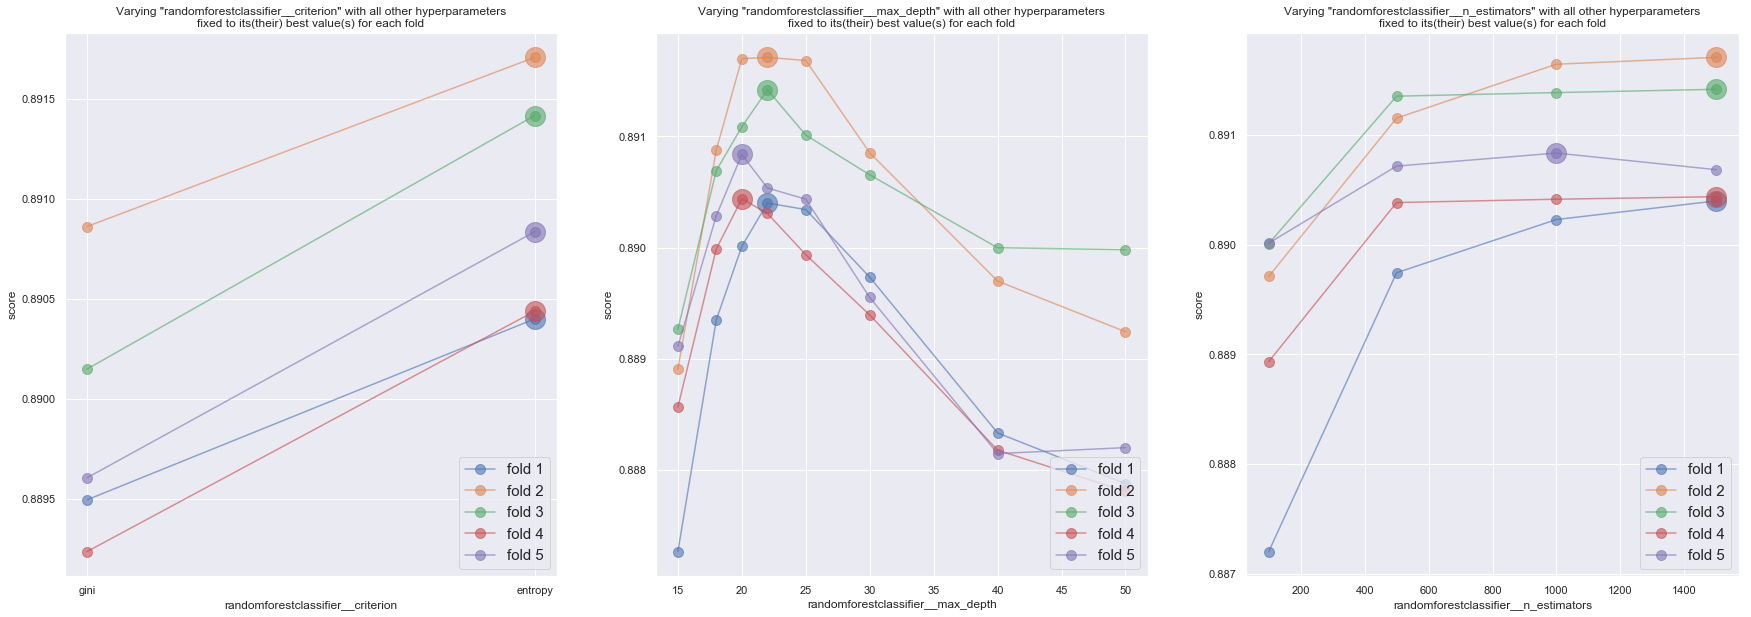

In [13]:
job.metrics.plot_grid_search_results(plot_error_bar=False)

In [49]:
summary.add(job.metrics, 'RandomForest', 'purple')

Fit model... done! (5.97s)


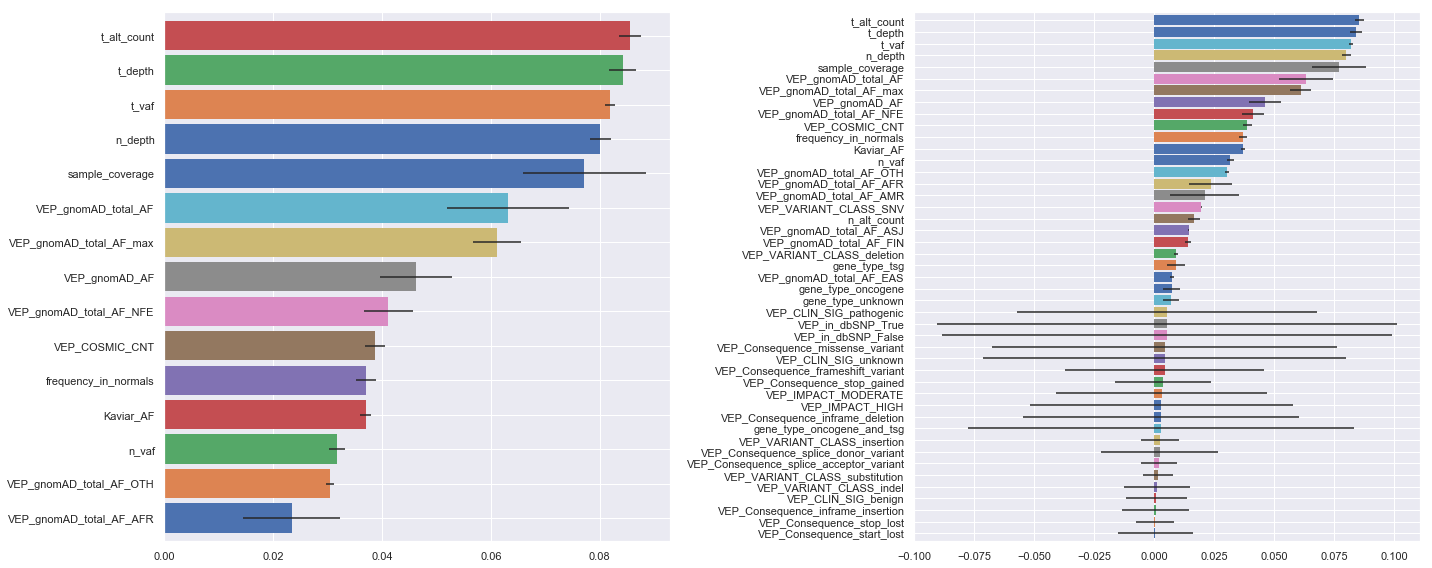

In [7]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                             RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5))

metrics = Metrics(model_bestRF, X, y, cv_strategy, n_jobs=5, run_model=False)
metrics.plot_features_importance(random_forest=True, pipeline_step_index=1)

# Gradient Boosting

In [71]:
job = Selene_Job('GradientBoosting', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs')

➞ mkdir on local computer ssh_remote_jobs/job_GradientBoosting


<span style="color:green">Job < GradientBoosting >: </span>✅ created

In [73]:
job = Selene_Job('GradientBoosting', 'guilminp', '/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < GradientBoosting >: </span>✅ job found and reloaded

In [63]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_GradientBoosting


<span style="color:green">Job < GradientBoosting >: </span>✅ data loaded

In [64]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../../../../utils/Python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# choose a model and run it
from sklearn.ensemble import GradientBoostingClassifier
parameters_grid = [
                    {'gradientboostingclassifier__loss': ['deviance', 'exponential'],
                     'gradientboostingclassifier__learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2],
                     'gradientboostingclassifier__n_estimators': [20, 50, 100, 500, 800],
                     'gradientboostingclassifier__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20]}
                  ]
pipe = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                     GradientBoostingClassifier(random_state=42))
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_GradientBoosting/script.ipy


In [74]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ssh_remote_jobs/job_GradientBoosting to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_GradientBoosting
job_output.txt                                100% 1537   156.6KB/s   00:00    
metrics.pkl                                   100% 7007KB  10.8MB/s   00:00    
script.ipy                                    100% 1505    70.0KB/s   00:00    
X.pkl                                         100%   44MB  11.1MB/s   00:04    
y.pkl                                         100% 3225KB  10.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/somatic_classification/ssh_remote_jobs/job_GradientBoosting
Job <30363799> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J GradientBoosting -n 5 -R "span[pt

<span style="color:green">Job < GradientBoosting >: </span>✅ submitted<br>

In [75]:
job.get_results()

<span style="color:red">Job < GradientBoosting >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.588 ± 0.016
▴ Mean roc_auc          : 0.897 ± 0.005
▴ Mean precision        : 0.209 ± 0.009
▴ Mean recall           : 0.763 ± 0.025
▴ Mean f1               : 0.328 ± 0.010
▴ Mean accuracy         : 0.884 ± 0.007


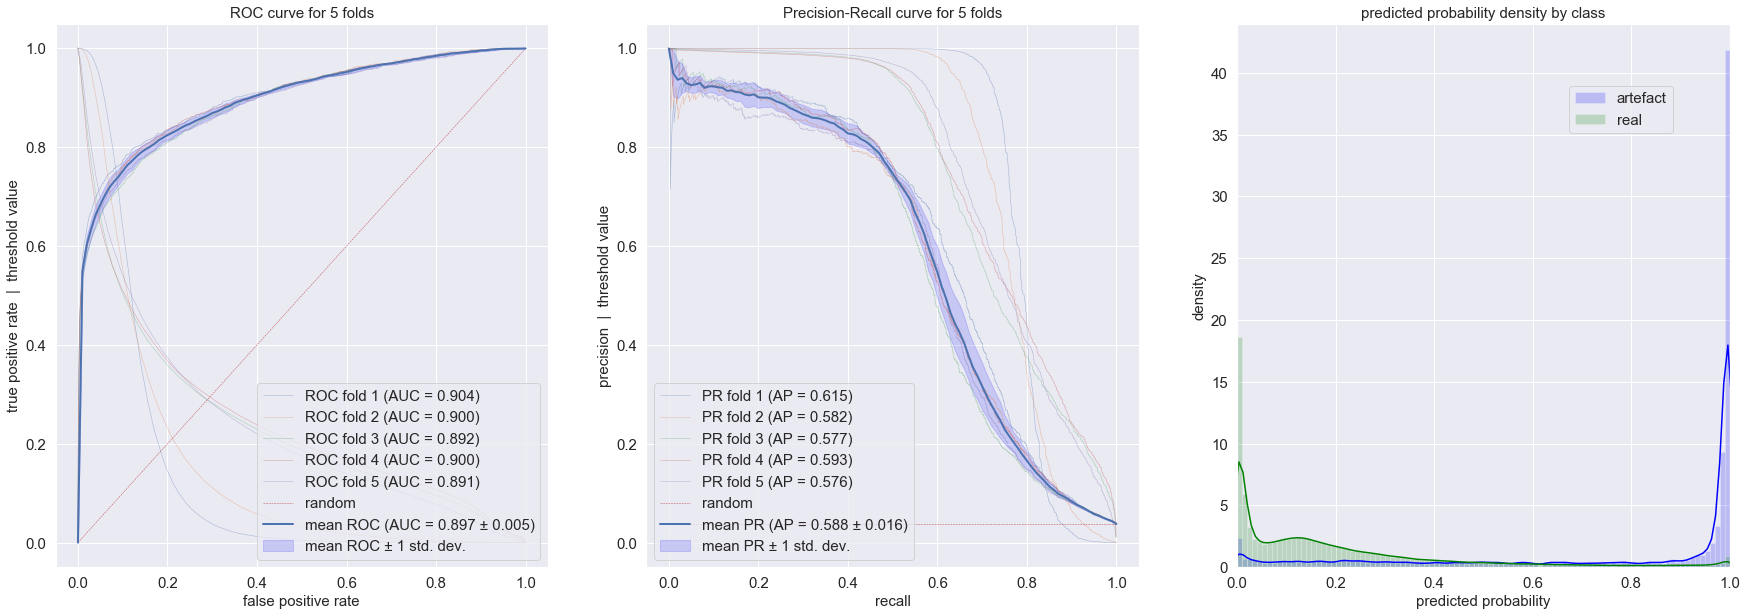

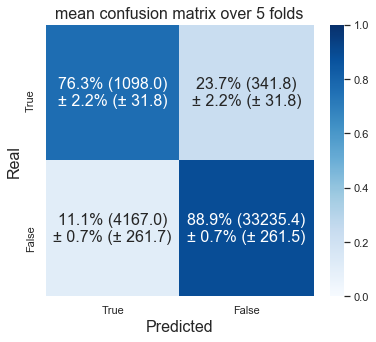

In [16]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves()
job.metrics.plot_mean_confusion_matrix()

4 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → gradientboostingclassifier__learning_rate: [0.05 0.08 0.09 0.1 0.11 0.12 0.2]
  → gradientboostingclassifier__loss         : ['deviance' 'exponential']
  → gradientboostingclassifier__max_depth    : [4 5 6 7 8 9 10 11 12 20]
  → gradientboostingclassifier__n_estimators : [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'gradientboostingclassifier__learning_rate': 0.12, 'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__max_depth': 12, 'gradientboostingclassifier__n_estimators': 500}
fold 1: {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__max_depth': 9, 'gradientboostingclassifier__n_estimators': 500}
fold 2: {'gradientboostingclassifier__learning_rate': 0.12, 'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassi

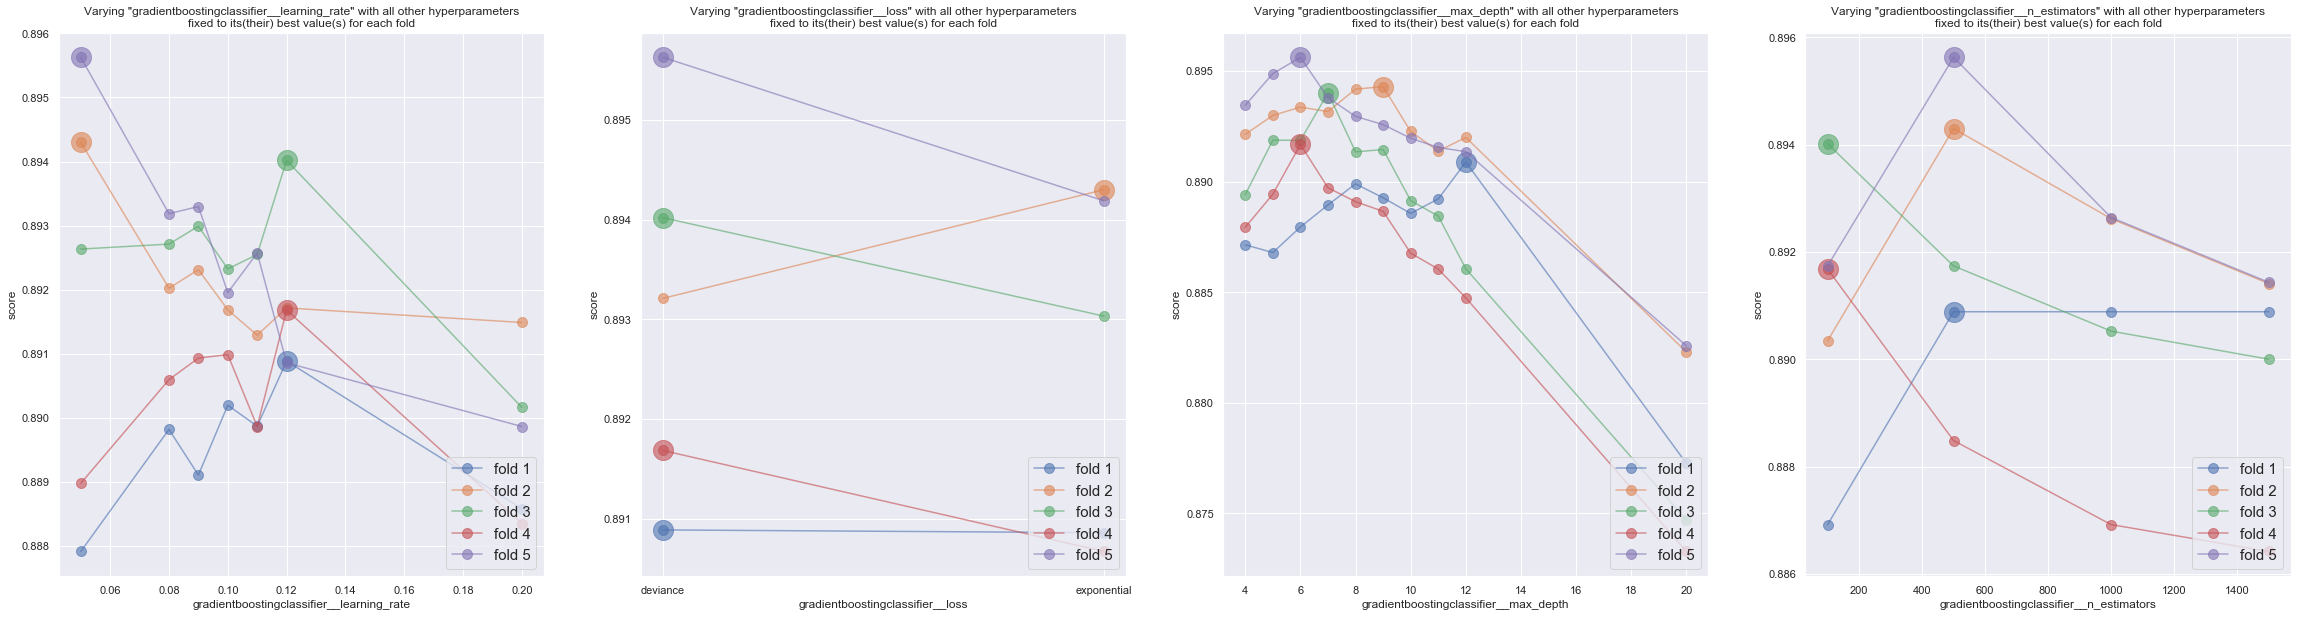

In [17]:
job.metrics.plot_grid_search_results(plot_error_bar = False)

In [52]:
summary.add(job.metrics, 'GradientBoosting', 'darkblue')

Fit model... done! (185.60s)


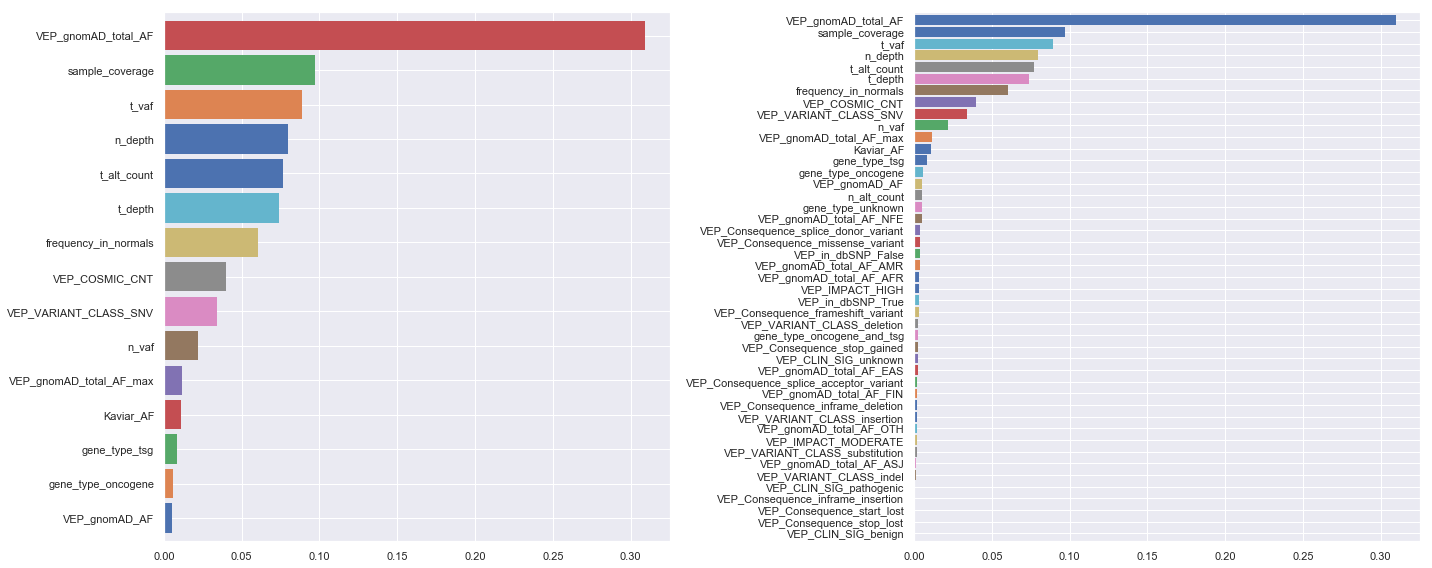

In [100]:
from sklearn.ensemble import GradientBoostingClassifier

model_bestGB = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                             GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=1000, max_depth=10, loss='deviance'))

metrics = Metrics(model_bestGB, X, y, cv_strategy, n_jobs=5, run_model=False)
metrics.plot_features_importance(random_forest=False, pipeline_step_index=1)

# Summary

In [54]:
#summary.save('summaries/algorithm_comparison.pkl')

In [55]:
summary = Summary()
summary.load('summaries/algorithm_comparison.pkl')

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
Uniform,0.0371,0.5,0.0373,0.505,0.0695,0.499
MostFrequent,0.0371,0.5,0,0,0,0.963
GausssianNaiveBayes,0.33,0.826,0.48,0.437,0.455,0.961
RidgeRegression,0.495,0.845,0.2,0.664,0.308,0.889
LassoRegression,0.496,0.845,0.198,0.665,0.305,0.888
kNN,0.475,0.86,0.185,0.692,0.292,0.876
SVM,0.446,0.857,0.228,0.674,0.341,0.903
RandomForest,0.588,0.894,0.224,0.739,0.343,0.895
GradientBoosting,0.588,0.897,0.209,0.763,0.328,0.884


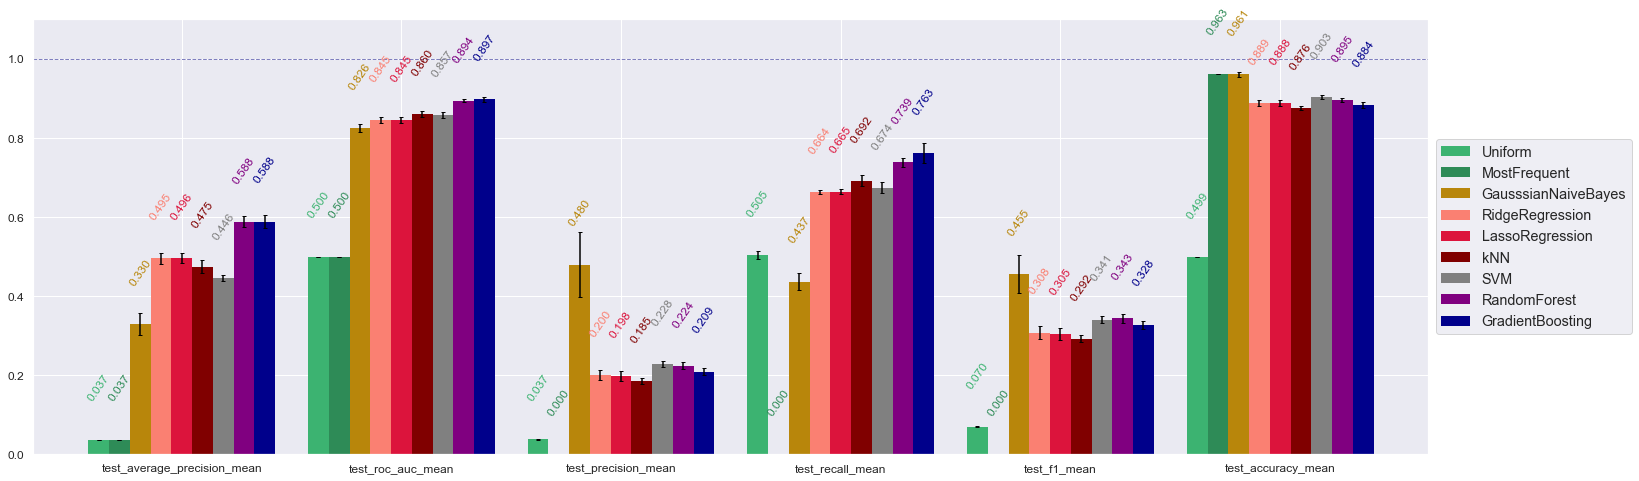

In [56]:
summary.display()
summary.plot()